<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>Instantaneous Frequency Estimation</h1> 
</div>

<br/>

<p>
Following Section 8.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook the notation of instantaneous frequency and show how it can be estimated.  
</p> 

## Introduction

In many music processing tasks, the first step is to convert the audio signal into a [time&ndash;frequency representation using an STFT](../C2/C2_STFT-Basic.html), which introduces a linear frequency grid. In the following we introduce a technique referred to as **instantaneous frequency estimation**. The estimates, which are derived by looking at the STFT's phase information, allows for improving the frequency quantization introduced by the STFT. We have seen alternative approaches in the [FMP notebook on frequency grid density](../C2/C2_STFT-FreqGridDensity.html) and in the [FMP notebook on frequency interpolation](../C2/C2_STFT-FreqGridInterpol.html).

We now summarize some properties of the [discrete STFT](../C2/C2_STFT-Basic.html), while fixing some notation. Let $x$ denote the given music signal sampled at a rate of $F_\mathrm{s}$ Hertz. Furthermore, let $\mathcal{X}$ be its STFT using a suitable window function of length $N\in\mathbb{N}$ and hop size $H\in\mathbb{N}$. Recall that, for the Fourier coefficient $\mathcal{X}(n,k)$, the frame index $n\in\mathbb{Z}$ is associated to the physical time 

\begin{equation}
         T_\mathrm{coef}(n) := \frac{n\cdot H}{F_\mathrm{s}}
\end{equation}

(given in seconds) and the frequency index $k\in[0:N/2]$ corresponds to the frequency

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

(given in Hertz). In particular, the discrete STFT introduces a linear sampling of the frequency axis with a resolution of $F_\mathrm{s}/N$ Hz. This resolution may not suffice to accurately capture certain time&ndash;frequency patterns (e.\,g., continuously changing patterns due to vibrato or glissando). Furthermore, because of the logarithmic perception of frequency, the linear sampling of the frequency axis becomes particularly problematic for the low-frequency part of the spectrum. Increasing the frequency resolution by simply increasing the window length $N$ is not a viable solution, since this process decreases the temporal resolution. In the following, we discuss a technique for obtaining an enhanced frequency estimation by exploiting the phase information encoded in the complex-valued STFT.

## Instantaneous Frequency

In order to explain this technique, let us start by recalling the main ideas of expressing and measuring frequency. As our prototypical oscillations, we consider complex-valued [**exponential functions**](../C2/C2_ExponentialFunction.html) of the form

\begin{equation}
\mathbf{exp}_{\omega,\varphi}:\mathbb{R}\to\mathbb{C}, \quad \mathbf{exp}_\omega(t):= \mathrm{exp}\big(2\pi i(\omega t - \varphi)\big)
\end{equation}

for a  frequency parameter $\omega\in\mathbb{R}$ (measured in $\mathrm{Hz}$) and a phase parameter $\varphi$ (measured in normalized radians with $1$ corresponding to an angle of $360^\circ$). In the case $\varphi=0$, we set

$$
\mathbf{exp}_{\omega} := \mathbf{exp}_{\omega,0}.
$$

Uniformly increasing the time parameter $t$, the exponential function describes a **circular motion** around the unit circle. When projected onto the real and imaginary axes, this yields two **sinusoidal motions** (described by a cosine and a sine function). Thinking of the circular motion as a uniformly rotating wheel, the frequency parameter $\omega$ corresponds to the number of revolutions per unit time (in our case, the duration of one second). In other words, the frequency can be interpreted as the rate of rotation. Based on this interpretation, one can associate a frequency value with a rotating wheel for arbitrary time intervals $[t_1,t_2]$ with $t_1<t_2$. To this end, one measures the angular position $\varphi_1$ at time $t_1$ and the angular position $\varphi_2$ at time $t_2$. This is illustrated by the following figure:

<img src="../data/C8/FMP_C8_F12.png" width="300px" align="middle" alt="FMP_C8_F12">

The frequency is then defined as the change $\varphi_2-\varphi_1$ in angular position
divided by the length $t_2-t_1$ of the time interval. In the limit case, when the time interval becomes arbitrarily small, one obtains the **instantaneous frequency** $\omega_{t_1}$ given by

\begin{equation}
        \omega_{t_1}:=\lim_{t_2\to t_1}\frac{\varphi_2-\varphi_1}{t_2-t_1}.
\end{equation}

## Phase Prediction Error

For the moment, let us assume a time-continuous perspective, fixing a frequency value $\omega\in\mathbb{R}$ and two time instances, say $t_1\in\mathbb{R}$ and $t_2\in\mathbb{R}$. Later, we will choose specific values that are related to the STFT parameters. Correlating the signal $x$ with a windowed version of the analysis function $\mathbf{exp}_\omega$, one positioned at $t_1$ and one at $t_2$, we obtain two complex Fourier coefficients. Let $\varphi_1$ and $\varphi_2$ be the phases of these two coefficients, respectively. In the case that the signal $x$ contains a strong frequency component of frequency $\omega$, the two phases $\varphi_1$ and $\varphi_2$ should be consistent in the following way: A rotation of frequency $\omega$ that assumes the angular position $\varphi_1$ at time position $t_1$ should have the phase

\begin{equation}
        \varphi^\mathrm{Pred}:=\varphi_1 + \omega\cdot \Delta t
\end{equation}

at time $t_2$, where $\Delta t:=t_2-t_1$. Therefore, in the case that the signal $x$ behaves similarly to the function $\mathbf{exp}_\omega$, one should have $\varphi_2\approx\varphi^\mathrm{Pred}$. In the case that the signal $x$ oscillates slightly slower than $\mathbf{exp}_\omega$, the phase increment from time instance $t_1$ to instance $t_2$ for the signal $x$ is less than the one for the prototype oscillation $\mathbf{exp}_\omega$. As a result, the phase $\varphi_2$ measured at $t_2$ is less than the predicted phase $\varphi^\mathrm{Pred}$. In the third case that $x$ oscillates slightly faster than $\mathbf{exp}_\omega$, the phase $\varphi_2$ is larger than the predicted phase $\varphi^\mathrm{Pred}$. The three cases are illustrated by the following figure:

<img src="../data/C8/FMP_C8_F13.png" width="400px" align="middle" alt="FMP_C8_F13">

To measure the difference between $\varphi_2$ and $\varphi^\mathrm{Pred}$, we introduce the **prediction error** defined by

\begin{equation}
        \varphi^\mathrm{Err}:=\Psi(\varphi_2-\varphi^\mathrm{Pred}).   
\end{equation}

In this definition, $\Psi:\mathbb{R}\to\left[-0.5,0.5\right]$ is the [**principal argument function**](../C6/C6S1_NoveltyPhase.html), which maps phase differences into the range $[-0.5,0.5]$ by adding or subtracting a suitable integer value, thus avoiding discontinuities when computing phase differences. The prediction error can be used to correct the frequency value $\omega$ to obtain a refined frequency estimate $\mathrm{IF}(\omega)$ for the signal $x$:

\begin{equation}
\label{eq:AudioDeco:Mel:IFE:freqEstCor}
   \mathrm{IF}(\omega) :=  \omega + \frac{\varphi^\mathrm{Err}}{\Delta t}.
\end{equation}

This value (being a bit sloppy in word use) is also called the **instantaneous frequency** (IF), which can be thought of an adjustment of the initial frequency $\omega$. Strictly speaking, rather than referring to a single time instance, the instantaneous frequency refers&mdash;in this case&mdash;to an entire time interval $[t_1,t_2]$. In practice, however, this interval is typically chosen to be very small (on the order of a couple of milliseconds).

## Improving the STFT Frequency Resolution

We now apply the concept of instantaneous frequency for improving the frequency resolution of a discrete STFT. Using the [polar coordinate representation](../C2/C2_ComplexNumbers.html), a Fourier coefficient $\mathcal{X}(n,k)\in\mathbb{C}$ can be written as

\begin{equation}
   \mathcal{X}(n,k)= |\mathcal{X}(n,k)|\mathrm{exp}(2\pi i\varphi(n,k))
\end{equation}

with the phase $\varphi(n,k)\in[0,1)$. For the prototype oscillation, we use the frequency determined by the frequency parameter $k\in[0:N/2]$: 

\begin{equation}
         \omega = F_\mathrm{coef}(k) = \frac{k\cdot F_\mathrm{s}}{N}.
\end{equation}

Furthermore, the two time instances are determined by the positions of the previous frame and the current frame:

\begin{equation}
     t_1=T_\mathrm{coef}(n-1)=\frac{(n-1)\cdot H}{F_\mathrm{s}} \quad\mbox{and}\quad
         t_2=T_\mathrm{coef}(n)=\frac{n\cdot H}{F_\mathrm{s}}.
\end{equation} 

Finally, the measured phases at these time instances are the ones obtained by the STFT:

\begin{equation}
     \varphi_1=\varphi(n-1,k) \quad\mbox{and}\quad
     \varphi_2=\varphi(n,k).
\end{equation}  

From this, using the above equations and doing some rearrangements, we obtain the instantaneous frequency 

\begin{equation}
    F_\mathrm{coef}^\mathrm{IF}(k,n):=\mathrm{IF}(\omega) = \left( k + \kappa(k,n) \right)\cdot\frac{F_\mathrm{s}}{N}
\end{equation}

where the **bin offset** $\kappa(k,n)$ is calculated as

\begin{equation}
     \kappa(k,n) = \frac{N}{H}\cdot\Psi\left(\varphi(n,k)-\varphi(n-1,k) - \frac{k\cdot H}{N}\right).
\end{equation} 

## Implementation

In the next code cell, we provide an implementation for the above procedure that estimate the instantaneous frequency (IF) for all time-frequency bins of a given STFT.

* The input of the procedure consists of the sampling rate `Fs`, the window length `N`, the hops size `H`, and a complex-valued STFT matrix `X` of dimension `K` (number of frequency bins) and `L` (number of frames).

* The output is a real-valued matrix `F_coef_IF` that contains the estimates of the IFs for each time-frequency bin. We apply padding so that `F_coef_IF` is also a (`K` $\times$ `L`)-matrix

* In the implementation, the IF is computed simultaneously for all time-frequency bins using matrix operations.

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd
from numba import jit

sys.path.append('..')
import libfmp.b

%matplotlib inline

@jit(nopython=True)
def principal_argument(v):
    """Principal argument function

    | Notebook: C6/C6S1_NoveltyPhase.ipynb, see also
    | Notebook: C8/C8S2_InstantFreqEstimation.ipynb

    Args:
        v (float or np.ndarray): Value (or vector of values)

    Returns:
        w (float or np.ndarray): Principle value of v
    """
    w = np.mod(v + 0.5, 1) - 0.5
    return w

@jit(nopython=True)
def compute_if(X, Fs, N, H):
    """Instantenous frequency (IF) estamation

    | Notebook: C8/C8S2_InstantFreqEstimation.ipynb, see also
    | Notebook: C6/C6S1_NoveltyPhase.ipynb

    Args:
        X (np.ndarray): STFT
        Fs (scalar): Sampling rate
        N (int): Window size in samples
        H (int): Hop size in samples

    Returns:
        F_coef_IF (np.ndarray): Matrix of IF values
    """
    phi_1 = np.angle(X[:, 0:-1]) / (2 * np.pi)
    phi_2 = np.angle(X[:, 1:]) / (2 * np.pi)

    K = X.shape[0]
    index_k = np.arange(0, K).reshape(-1, 1)
    # Bin offset (FMP, Eq. (8.45))
    kappa = (N / H) * principal_argument(phi_2 - phi_1 - index_k * H / N)
    # Instantaneous frequencies (FMP, Eq. (8.44))
    F_coef_IF = (index_k + kappa) * Fs / N

    # Extend F_coef_IF by copying first column to match dimensions of X
    F_coef_IF = np.hstack((np.copy(F_coef_IF[:, 0]).reshape(-1, 1), F_coef_IF))

    return F_coef_IF

## Visualization of IF Values

We now introduce a visualization that provides some deeper insights into the IF estimation procedure. As example, we consider a recording or a single note $\mathrm{C4}$ played on a piano. This note corresponds to MIDI pitch $p=60$ having a [center frequency](../C1/C1S3_FrequencyPitch.html) of $261.6~\mathrm{Hz}$. The following figure shows the waveform and a spectrogram representation of the audio signal. 

<audio src="../data/C8/FMP_C8_NoteC4_Piano.wav" type="audio/mpeg" controls="controls" style="width: 200px;"></audio>


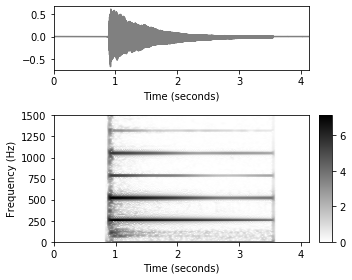

In [2]:
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_NoteC4_Piano.wav')
x, Fs = librosa.load(fn_wav)

N = 2048
H = 64
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
Y = np.log(1+ 10*np.abs(X))
K = X.shape[0]
L = X.shape[1]
ylim = [0,1500]

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2]}, figsize=(5, 4))        

libfmp.b.plot_signal(x, Fs, ax=ax[0,0])
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1,0],ax[1,1]], colorbar=True)
ax[1,0].set_ylim(ylim)
plt.tight_layout()

The output of the IF estimation is a frequency value $F_\mathrm{coef}^\mathrm{IF}(k,n)\in\mathbb{R}$ (given in Hertz) for $k\in[0:K-1]$ and $n\in[0:L-1]$. This value is a refinement of the (frame-independent) frequency value $F_\mathrm{coef}(k)$ that is associated to the $k^\mathrm{th}$ Fourier coefficient of the STFT. In the following figure, we show the $(K\times N)$-matrices given by $F_\mathrm{coef}$ and by  $F_\mathrm{coef}^\mathrm{IF}$ in a color-coded form. Furthermore, we also visualize the difference

$$F_\mathrm{coef}^\mathrm{IF}-F_\mathrm{coef} = \kappa \cdot\frac{N}{F_\mathrm{s}},$$

which is the bin offset specified in Hertz. Note that opposed to visualizing a spectrogram (were the magnitudes are color-coded), this time we **visualize frequency values** (given in Hertz).

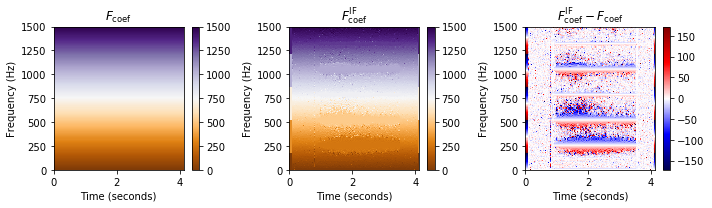

In [3]:
def plot_IF(F_coef_X, F_coef_IF, ylim, figsize=(10,3)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,3,1)
    libfmp.b.plot_matrix(F_coef_X, Fs=Fs/H, Fs_F=N/Fs, cmap='PuOr', clim=ylim, ax=[ax],
            title=r'$F_\mathrm{coef}$')
    plt.ylim(ylim)
    ax = plt.subplot(1,3,2)
    libfmp.b.plot_matrix(F_coef_IF, Fs=Fs/H, Fs_F=N/Fs, cmap='PuOr', clim=ylim, ax=[ax],
            title=r'$F_\mathrm{coef}^\mathrm{IF}$')
    plt.ylim(ylim)
    ax = plt.subplot(1,3,3)
    libfmp.b.plot_matrix(F_coef_IF-F_coef_X, Fs=Fs/H, Fs_F=N/Fs, cmap='seismic', ax=[ax],
            title=r'$F_\mathrm{coef}^\mathrm{IF}-F_\mathrm{coef}$')
    plt.ylim(ylim)
    plt.tight_layout()
    
F_coef_IF = compute_if(X, Fs, N, H)
F_coef = np.arange(K) * Fs / N
F_coef_X = np.ones((K,L)) * F_coef.reshape(-1,1)
plot_IF(F_coef_X, F_coef_IF, ylim)    

In this visualization, the matrices $F_\mathrm{coef}$ and $F_\mathrm{coef}^\mathrm{IF}$ look quite similar. However, in the visualization of the difference one can clearly see the adjustment of frequency values in regions along the fundamental frequency of the note $\mathrm{C4}$ ($261.6~\mathrm{Hz}$) and its harmonics. Frequency values just below a harmonic are adjusted upwards (red color) and frequency values just above a harmonic are corrected downwards (blue color). In the next figure, we zoom into a neighborhood of the fundamental frequency $261.6~\mathrm{Hz}$, while adjusting the color coding for frequency values. This visualization indicates that the IF estimation procedure assigns all frequency coefficients in a neighborhood of $261.6~\mathrm{Hz}$ to exactly that frequency. We will show in the [FMP notebook on salience representations](../C8/C8S2_SalienceRepresentation.html) how this reassignment procedure can be used to overcome the limitations of the linear frequencies grid introduced by the discrete STFT.

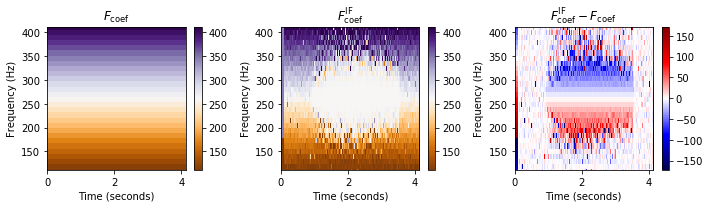

In [4]:
# Compute a neighborhood around center frequency of C4 (p=60)
pitch = 60
freq_fund = 2 ** ((pitch - 69) / 12) * 440
freq_0 = freq_fund-150
freq_1 = freq_fund+150
ylim = [freq_0, freq_1]

plot_IF(F_coef_X, F_coef_IF, ylim)  

## Dependency on Hop Size

Note that the quality of the estimated instantaneous frequency depends, among other parameters, on the length 

$$
\Delta t=t_2-t_1 = T_\mathrm{coef}(n) - T_\mathrm{coef}(n-1) = H/F_\mathrm{s}
$$ 

between two subsequent frames. Therefore, when applied to the discrete STFT, it is beneficial to use a **small hop size** $H$. This is illustrated by the next figures. On the downside, using a small hop size increases the computational cost for calculating the discrete STFT. 

Instanteneous frequency estimation using N=2048 and H=64
Runtime (STFT): 0.02314210 seconds
Runtime (IF): 0.15846300 seconds


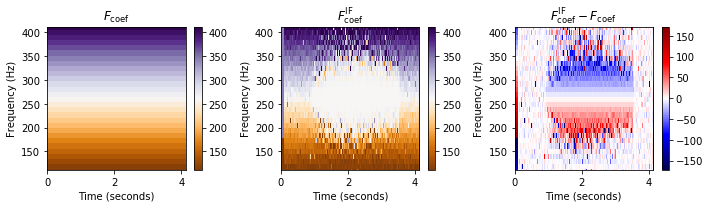

Instanteneous frequency estimation using N=2048 and H=256
Runtime (STFT): 0.00614977 seconds
Runtime (IF): 0.04060292 seconds


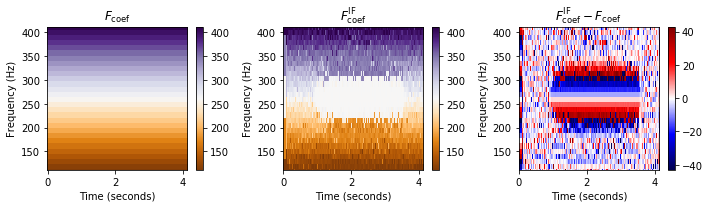

Instanteneous frequency estimation using N=2048 and H=1024
Runtime (STFT): 0.00242019 seconds
Runtime (IF): 0.00932360 seconds


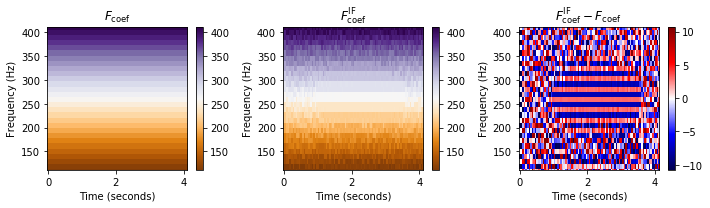

In [5]:
import time

def compute_plot_IF(x, N, H):
    
    # Compute STFT
    start = time.time()
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    Y = np.log(1+ 10*np.abs(X))
    end = time.time()
    print('Runtime (STFT): %.8f seconds' % (end - start))    
    K = X.shape[0]
    L = X.shape[1]
    
    # Compute IF
    start = time.time()
    F_coef_IF = compute_if(X, Fs, N, H)
    end = time.time()
    print('Runtime (IF): %.8f seconds' % (end - start))    
    
    # Plot
    F_coef = np.arange(K) * Fs / N
    F_coef_X = np.ones((K,L)) * F_coef.reshape(-1,1)
    plot_IF(F_coef_X, F_coef_IF, ylim) 
    plt.show()
    
N, H = 2048, 64
print('Instanteneous frequency estimation using N=%d and H=%d'%(N,H))
compute_plot_IF(x, N, H)

N, H = 2048, 256
print('Instanteneous frequency estimation using N=%d and H=%d'%(N,H))
compute_plot_IF(x, N, H)

N, H = 2048, 1024
print('Instanteneous frequency estimation using N=%d and H=%d'%(N,H))
compute_plot_IF(x, N, H)

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/rosenzweig">Sebastian Rosenzweig</a>.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>